In [2]:
import sys
sys.path.append('C:\\Users\\xpy\\work\\strategies2py\\AprilQuant')
import warnings
from collections import defaultdict, OrderedDict

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import empyrical

from backtest.return_rate_calculations import (
    cal_avg_cum_ret, 
    avg_cum_ret_from_cursor, 
    ret_from_cum_ret, 
    cum_ret_from_doc
)
from utils import query, plot_curves
from backtest.check_for_momentum import (
    get_cum_ret_dict,
    cal_strategy_overall_tendency
)
from consts import C_DAILY

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

DB = 'C76'

In [10]:
fast_length_rng = (15, 20, 25, 30, 35)
slow_length_rng = (85, 100, 115, 130, 145)
macd_length_rng = (5, 7, 9, 11, 13)
chandelier_rng_d = dict(trs=(0.12,))
chandelier_rng_m = dict(trs=(0.06,))


hist_len_rng = (240, 480, 720, 960, 1200)
pred_len_rng = (20, 60, 120, 240)

params = [(hist_len, pred_len) for pred_len in pred_len_rng for hist_len in hist_len_rng]

performances = get_cum_ret_dict(DB, 'daily', fast_length=25, slow_length=115, macd_length=9, trs=0.12)

lines = []
for param in params:
    line = cal_strategy_overall_tendency(performances, param[0], param[1])
    lines.append(line)
summary = pd.DataFrame(lines).sort_values('hist_len')
display(summary)

,hist_len,pred_len,category_num,sig_pos_related,sig_neg_related,successful_prediction
0,240,20,44,0.159091,0.568182,0.295455
5,240,60,42,0.166667,0.690476,0.261905
10,240,120,39,0.102564,0.769231,0.230769
15,240,240,38,0.131579,0.736842,0.184211
1,480,20,39,0.153846,0.641026,0.153846
6,480,60,38,0.131579,0.684211,0.078947
11,480,120,34,0.147059,0.823529,0.117647
16,480,240,34,0.088235,0.882353,0.147059
2,720,20,34,0.088235,0.823529,0.058824
17,720,240,31,0.129032,0.838710,0.225806


In [11]:
from backtest.tester import Tester
from backtest.indicators import ATR, AllNaError
Tester.read_cache('daily')

performances = get_cum_ret_dict(DB, 'daily', fast_length=25, slow_length=115, macd_length=9, trs=0.12)
cum_ret_df = pd.DataFrame({k: v.cum_ret for k, v in performances.items()})
crd = cal_avg_cum_ret(performances.values())

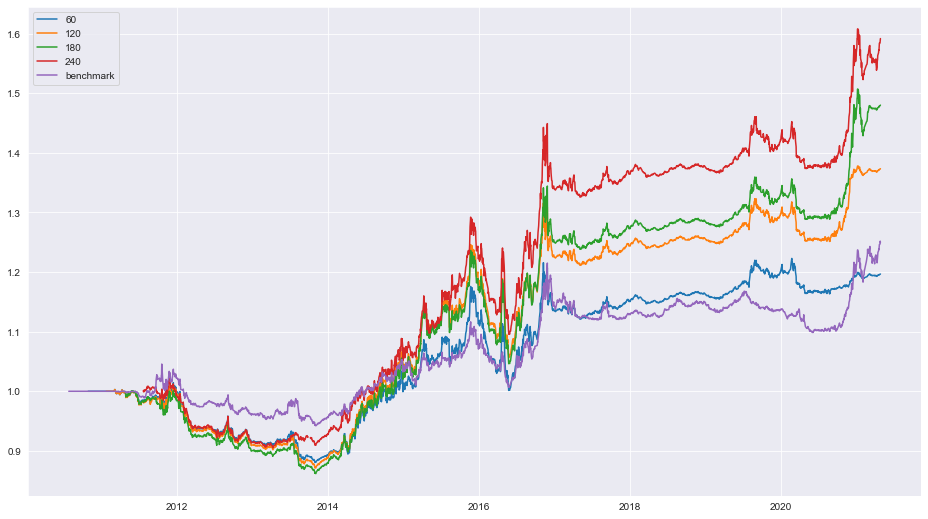

In [12]:
atr_length_rng = (60, 120, 180, 240)

weighted_cum_rets = []
for atr_length in atr_length_rng:

    atr_dict = dict()
    for c, df_list in Tester.backtest_data.items():
        for i, df in enumerate(df_list):
            df = df.set_index('datetime')
            try:
                atr = ATR(high=df.adjusted_high, low=df.adjusted_low, close=df.adjusted_close, timeperiod=atr_length)
            except AllNaError:
                continue
            else:
                atr_dict[f'{c}-{i}'] = atr

    atr_df = pd.DataFrame({k: v for k, v in atr_dict.items() if k in performances})
    atr_df = 1 / atr_df
    weight = atr_df.apply(lambda x: x / x.sum(), axis=1)
    
    weight = weight.fillna(0)
    selected_line = range(0, len(weight), 60)
    selected_time = weight.iloc[selected_line].index
    weight.loc[~weight.index.isin(selected_time), :] = None
    weight.fillna(method='ffill', inplace=True)

    ret_value = (cum_ret_df.diff() * weight).sum(axis=1)
    cost_df = (cum_ret_df.shift(1) * weight).sum(axis=1)
    weighted_ret = ret_value / cost_df
    weighted_cum_ret = (1 + weighted_ret).cumprod()
    weighted_cum_rets.append(weighted_cum_ret)

plot_curves([*weighted_cum_rets, crd], '', ['60', '120', '180', '240', 'benchmark'])

In [13]:
empyrical.sharpe_ratio(weighted_ret)

0.7063570116076135

In [15]:
ret_adjusted = crd.diff() / crd.shift(1)
empyrical.sharpe_ratio(ret_adjusted)[0]

0.46024681958602637

In [3]:
from backtest.tester import Tester
from backtest.indicators import ATR, AllNaError
Tester.read_cache('30min')

performances = get_cum_ret_dict(DB, '30min', fast_length=25, slow_length=115, macd_length=9, trs=0.06)

cum_ret_df = pd.DataFrame({k: v.cum_ret for k, v in performances.items()})
crd = cal_avg_cum_ret(performances.values())

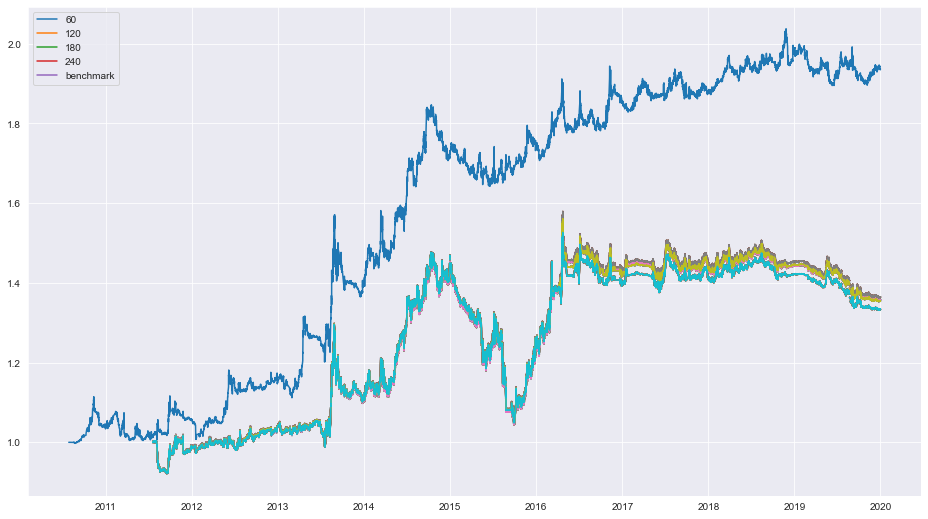

In [4]:
n = 10
atr_length_rng = (60, 120, 180, 240)*n

weighted_cum_rets = []
for atr_length in atr_length_rng:

    atr_dict = dict()
    for c, df_list in Tester.backtest_data.items():
        for i, df in enumerate(df_list):
            df = df.set_index('datetime')
            try:
                atr = ATR(high=df.adjusted_high, low=df.adjusted_low, close=df.adjusted_close, timeperiod=atr_length)
            except AllNaError:
                continue
            else:
                atr_dict[f'{c}-{i}'] = atr

    atr_df = pd.DataFrame({k: v for k, v in atr_dict.items() if k in performances})
    atr_df = 1 / atr_df
    weight = atr_df.apply(lambda x: x / x.sum(), axis=1)
    
    
        
    weight = weight.fillna(0)
    selected_line = range(0, len(weight), 240*n)
    selected_time = weight.iloc[selected_line].index
    weight.loc[~weight.index.isin(selected_time), :] = None
    weight.fillna(method='ffill', inplace=True)
    

    ret_value = (cum_ret_df.diff() * weight).sum(axis=1)
    cost_df = (cum_ret_df.shift(1) * weight).sum(axis=1)
    weighted_ret = ret_value / cost_df
    weighted_cum_ret = (1 + weighted_ret).cumprod()
    weighted_cum_rets.append(weighted_cum_ret)

plot_curves([*weighted_cum_rets, crd], '', ['60', '120', '180', '240', 'benchmark'])